## Capacitated vehicle routing problem (CVRP)

### Rounded capacity inequality model for the CVRP

In [1]:
# library
import networkx as nx
import random
import math
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

In [2]:
k = 4       # number of vehicles
n = 20      # number of demand points

depot = 0                       
dem_points = list(range(1,n+1)) # nodes 1, 2, ..., 20

G = nx.complete_graph(n+1)  

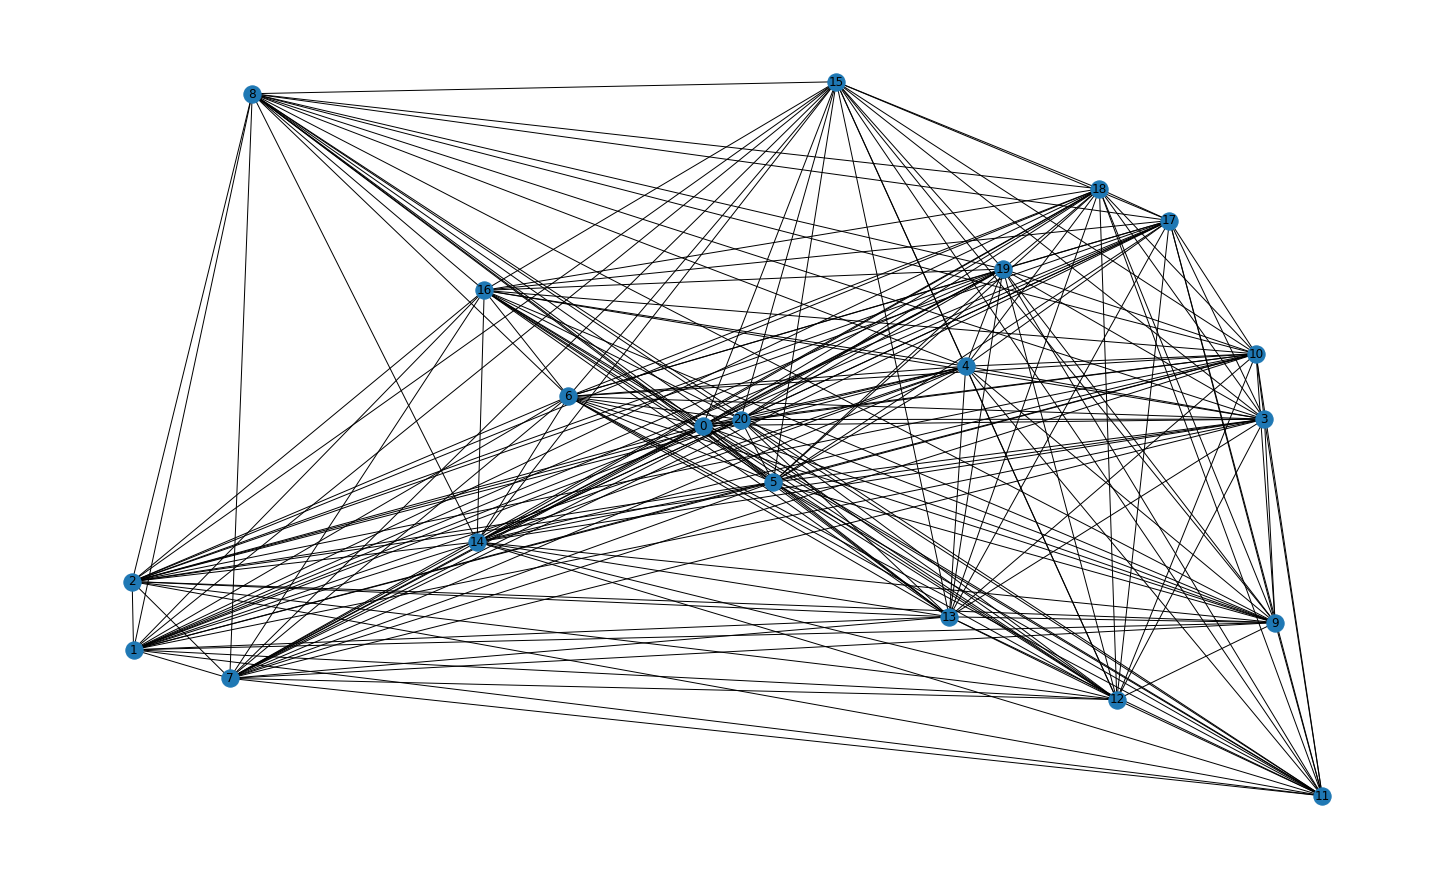

In [4]:
# pick the city (x,y)-coordinates at random

my_pos = { i : ( random.random(), random.random() ) for i in dem_points } # pos[i] = (x_i, y_i)

# let's locate the depot in the middle
my_pos[depot] = (0.5, 0.5)

plt.figure(figsize=(20,12))

nx.draw(G, pos=my_pos, with_labels="True")

In [5]:
# suppose that distances are Euclidean

def eucl_dist(x1,y1,x2,y2):
    return math.sqrt( (x1-x2)**2 + (y1-y2)**2 )

for i,j in G.edges:
    (x1,y1) = my_pos[i]
    (x2,y2) = my_pos[j]
    G.edges[i,j]['length'] = eucl_dist(x1,y1,x2,y2)

In [6]:
# suppose each vehicle has capacity 100
Q = 100

# suppose each demand point has demand 20
q = { i : 20 for i in dem_points }
q[depot] = 0

In [7]:
# config values

MAX_CPU_TIME = 3600.0
EPSILON = 1e-6

In [8]:
# First, solve a relaxation

# model
model = gp.Model()
x = model.addVars(G.edges,vtype=GRB.BINARY)

model.setObjective( gp.quicksum( G.edges[e]['length'] * x[e] for e in G.edges ), GRB.MINIMIZE )

# Degree-2 constraints
model.addConstrs( gp.quicksum( x[e] for e in G.edges if e in G.edges(i) ) == 2 for i in dem_points )

# Degree-(2*k) constraints at depot
model.addConstr( gp.quicksum( x[e] for e in G.edges if e in G.edges(depot) ) == 2*k )

model.update()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-15


In [17]:
# create a function to separate the rounded capacity inequalities (or subtour elimination)

def rounded_capacity_ineq(model, where):
    
    # check if LP relaxation at this branch-and-bound node has an integer solution
    if where == GRB.Callback.MIPSOL: 
        
        # retrieve the LP solution
        xval = model.cbGetSolution(model._x)
        
        # which edges are selected?
        tour_edges = [ e for e in model._G.edges if xval[e] > 0.5 ]
        
        # if connected, add rounded capacity inequalities (if any are violated)
        if nx.is_connected( model._G.edge_subgraph( tour_edges ) ):
            
            nondepot_edges = [ (i,j) for (i,j) in tour_edges if model._depot not in {i,j} ]
            
            for component in nx.connected_components( model._G.edge_subgraph( nondepot_edges ) ):
                
                component_demand = sum( model._q[i] for i in component )
                
                if component_demand > Q:
                    
                    cut_edges = [ (i,j) for (i,j) in model._G.edges if ( i in component) ^ ( j in component ) ]
                    model.cbLazy( gp.quicksum( model._x[e] for e in cut_edges ) >= 2 * math.ceil( component_demand / model._Q ) )
        
        # else, add subtour elimination constraints for non-depot components
        else: 
            
            for component in nx.connected_components( model._G.edge_subgraph( tour_edges ) ):
                
                if model._depot not in component:
                    
                    inner_edges = [ (i,j) for (i,j) in model._G.edges if i in component and j in component ]
                    model.cbLazy( gp.quicksum( model._x[e] for e in inner_edges ) <= len(component) - 1 )

In [18]:
# export .lp
#model.write(file_name+"_model.lp")

# parameters config
model.setParam(gp.GRB.Param.TimeLimit, MAX_CPU_TIME)
model.setParam(gp.GRB.Param.MIPGap, EPSILON)
model.setParam(gp.GRB.Param.Threads, 1)
#model.setParam(gp.GRB.Param.Cuts, -1)
#model.setParam(gp.GRB.Param.Presolve, -1)

# turn off display
gp.setParam('OutputFlag', 0)

# open log file
#_ = open('log/cvrp.log', 'w')

# tell Gurobi that we will be adding (lazy) constraints
model.Params.lazyConstraints = 1

# designate the callback routine 
model._callback = rounded_capacity_ineq

# add the variables and graph to our model object, for use in the callback
model._x = x
model._G = G
model._q = q
model._Q = Q
model._depot = depot

# solve the MIP with our callback
model.optimize(model._callback)

Set parameter TimeLimit to value 3600
Set parameter MIPGap to value 1e-06
Set parameter Threads to value 1


In [19]:
tmp = 0
if model.status == gp.GRB.OPTIMAL:
    tmp = 1

ub = model.objBound
lb = model.objVal
gap = model.MIPGap
time = model.Runtime
nodes = model.NodeCount
status = tmp

In [20]:
print("ub= ", round(ub,2))
print("lb =", round(lb,2))
print("gap = ", round(gap,2))
print("time = ", round(time,2))
print("nodes = ", round(nodes,2))
print("status = ", tmp)

ub=  5.53
lb = 5.53
gap =  0.0
time =  0.02
nodes =  1.0
status =  1


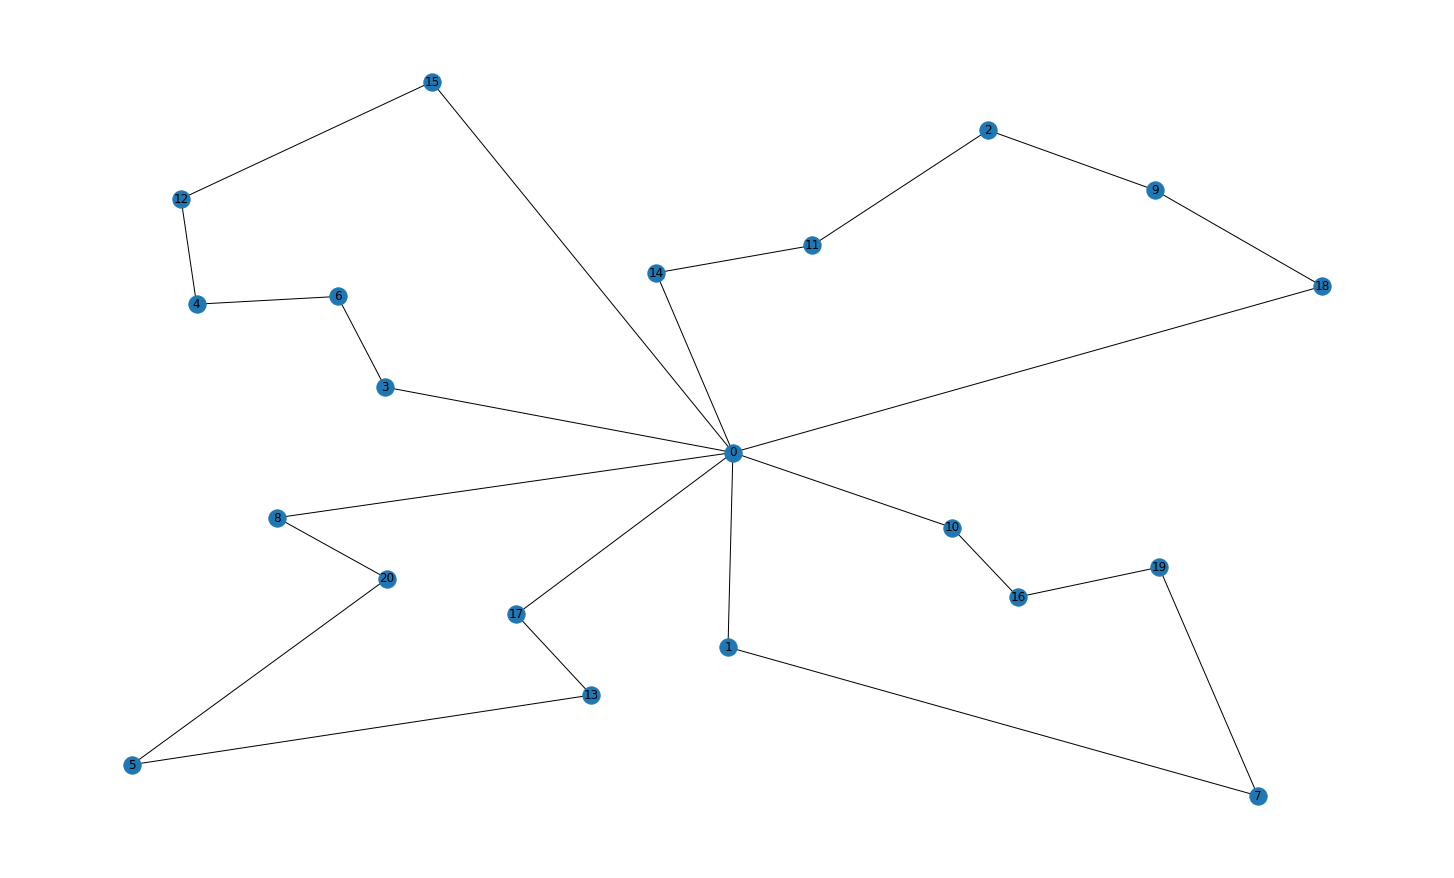

In [21]:
# get the solution and draw it
tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]

plt.figure(figsize=(20,12))

nx.draw(G.edge_subgraph(tour_edges), pos=my_pos, with_labels="True")